In [5]:
import pandas as pd
import re
import unicodedata
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2
import os
from dotenv import load_dotenv
from psycopg2.extras import execute_batch

In [ ]:
# 1. Cargar el dataset
file_path = "./Data/Vinculación_de_personas_con_discapacidad_20250919.csv"
df = pd.read_csv(file_path, sep=None, engine="python")

In [9]:
# 2. Copia de seguridad
df_clean = df.copy()

**ETL:**

In [10]:
# 3. Normalizar nombres de columnas
df_clean.columns = (
    df_clean.columns
    .str.strip()
    .str.upper()
    .str.replace(" ", "_")
    .str.replace(":", "")
    .str.replace("Á", "A")               # para evitar problemas con acentos
    .str.replace("É", "E")
    .str.replace("Í", "I")
    .str.replace("Ó", "O")         
    .str.replace("Ú", "U")
    .str.replace("Ñ", "N")
)

In [11]:
# 4. Reemplazar comas por puntos en coordenadas
df["Latitud"] = df["Latitud"].astype(str).str.replace(",", ".").astype(float)
df["Longitud"] = df["Longitud"].astype(str).str.replace(",", ".").astype(float)

In [12]:
# 5. Convertir columnas numéricas que vienen como texto
for col in ["Vinculados", "meta_vinculacion", "Salario mensual promedio"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")

In [13]:
# 6. Corregir año (algunos vienen con comas)
df["Año"] = df["Año"].astype(str).str.replace(",", "").astype(int)

In [14]:
# 7. Definir columnas que quiero conservar como claves
id_vars = [
    'Código SIGEP', 'Nombre de la entidad', 'Nit', 'Orden', 'Suborden',
    'Código DIVIPOLA Departamento', 'Departamento',
    'Código DIVIPOLA Municipio ', 'Municipio',
    'Clasificación Orgánica', 'Sector', 'Nivel',
    'Tipo de Vinculacíon ', 'Naturaleza jurídica ',
    'Longitud', 'Latitud', 'Año', 'Trimestre',
    'Fuente', 'Salario mensual promedio',
    'Vinculados', 'meta_vinculacion', 'cumplimiento'
]

In [15]:
# 8. Transformar columnas categóricas a vertical
df_long = pd.melt(
    df,
    id_vars=id_vars,
    var_name="categoria",
    value_name="valor"
)

In [16]:
# 9. Limpiar: eliminar solo valores nulos
df_long = df_long[df_long["valor"].notna()]

In [17]:
print(df_long.head(20))

    Código SIGEP                               Nombre de la entidad  \
0             40                                 ALCALDIA DE MAICAO   
1            223                              ALCALDIA DE CHINCHINA   
2            278                             ALCALDIA DE COPACABANA   
3            364                 UNIVERSIDAD TECNOLOGICA DE PEREIRA   
4            463                         ALCALDIA DE RIOFRIO  VALLE   
5            511                                  ALCALDIA DE YUMBO   
6            682                      ALCALDIA DE LA CEJA DEL TAMBO   
7            879                                ALCALDIA DE PIVIJAY   
8           1061                     ALCALDIA DE SAN MIGUEL DE SEMA   
9           1112                              ALCALDIA DE SANTUARIO   
10          1196                              ALCALDIA DE TOCANCIPA   
11          1681                                  CONCEJO DE GUICAN   
12          2157                                   CONCEJO DE FUNZA   
13    

In [18]:
# 10. Eliminar columnas innecesarias
cols_to_drop = [
    'Código SIGEP', 'Nit', 'Código DIVIPOLA Departamento',
    'Código DIVIPOLA Municipio ', 'Nivel', 'Tipo de Vinculacíon ',
    'Trimestre', 'Fuente'
]
df_long = df_long.drop(columns=cols_to_drop)

In [19]:
print(df_long.head(20))

                                 Nombre de la entidad        Orden  \
0                                  ALCALDIA DE MAICAO  TERRITORIAL   
1                               ALCALDIA DE CHINCHINA  TERRITORIAL   
2                              ALCALDIA DE COPACABANA  TERRITORIAL   
3                  UNIVERSIDAD TECNOLOGICA DE PEREIRA     NACIONAL   
4                          ALCALDIA DE RIOFRIO  VALLE  TERRITORIAL   
5                                   ALCALDIA DE YUMBO  TERRITORIAL   
6                       ALCALDIA DE LA CEJA DEL TAMBO  TERRITORIAL   
7                                 ALCALDIA DE PIVIJAY  TERRITORIAL   
8                      ALCALDIA DE SAN MIGUEL DE SEMA  TERRITORIAL   
9                               ALCALDIA DE SANTUARIO  TERRITORIAL   
10                              ALCALDIA DE TOCANCIPA  TERRITORIAL   
11                                  CONCEJO DE GUICAN  TERRITORIAL   
12                                   CONCEJO DE FUNZA  TERRITORIAL   
13  DEPARTAMENTO ADM

In [20]:
# 11. Crear nueva columna con la parte antes de los dos puntos
df_long["categoria_general"] = df_long["categoria"].str.split(":").str[0]

In [21]:
print(df_long.head(20))

                                 Nombre de la entidad        Orden  \
0                                  ALCALDIA DE MAICAO  TERRITORIAL   
1                               ALCALDIA DE CHINCHINA  TERRITORIAL   
2                              ALCALDIA DE COPACABANA  TERRITORIAL   
3                  UNIVERSIDAD TECNOLOGICA DE PEREIRA     NACIONAL   
4                          ALCALDIA DE RIOFRIO  VALLE  TERRITORIAL   
5                                   ALCALDIA DE YUMBO  TERRITORIAL   
6                       ALCALDIA DE LA CEJA DEL TAMBO  TERRITORIAL   
7                                 ALCALDIA DE PIVIJAY  TERRITORIAL   
8                      ALCALDIA DE SAN MIGUEL DE SEMA  TERRITORIAL   
9                               ALCALDIA DE SANTUARIO  TERRITORIAL   
10                              ALCALDIA DE TOCANCIPA  TERRITORIAL   
11                                  CONCEJO DE GUICAN  TERRITORIAL   
12                                   CONCEJO DE FUNZA  TERRITORIAL   
13  DEPARTAMENTO ADM

In [22]:
# 12) Función de limpieza: normaliza acentos, pasa a mayúsculas y quita caracteres especiales
def clean_text(s):
    if pd.isna(s):
        return s
    s = str(s)
    # Normalizar acentos (Á -> A, etc.)
    s = unicodedata.normalize('NFKD', s).encode('ASCII', 'ignore').decode('ASCII')
    # Pasar a mayúsculas
    s = s.upper()
    # Quitar cualquier caracter que no sea A-Z, 0-9 o espacio
    s = re.sub(r'[^A-Z0-9\s]', '', s)
    # Colapsar múltiples espacios y strip
    s = re.sub(r'\s+', ' ', s).strip()
    return s

In [23]:
# 13) Aplicar limpieza solo a columnas de tipo object (texto)
text_cols = df_long.select_dtypes(include="object").columns.tolist()
for col in text_cols:
    df_long[col] = df_long[col].apply(clean_text)

In [24]:
print(df_long.head(20))

                                 Nombre de la entidad        Orden  \
0                                  ALCALDIA DE MAICAO  TERRITORIAL   
1                               ALCALDIA DE CHINCHINA  TERRITORIAL   
2                              ALCALDIA DE COPACABANA  TERRITORIAL   
3                  UNIVERSIDAD TECNOLOGICA DE PEREIRA     NACIONAL   
4                           ALCALDIA DE RIOFRIO VALLE  TERRITORIAL   
5                                   ALCALDIA DE YUMBO  TERRITORIAL   
6                       ALCALDIA DE LA CEJA DEL TAMBO  TERRITORIAL   
7                                 ALCALDIA DE PIVIJAY  TERRITORIAL   
8                      ALCALDIA DE SAN MIGUEL DE SEMA  TERRITORIAL   
9                               ALCALDIA DE SANTUARIO  TERRITORIAL   
10                              ALCALDIA DE TOCANCIPA  TERRITORIAL   
11                                  CONCEJO DE GUICAN  TERRITORIAL   
12                                   CONCEJO DE FUNZA  TERRITORIAL   
13  DEPARTAMENTO ADM

**EDA:**

In [21]:
# 1. Resumen general
print("Dimensiones:", df_long.shape)
print("\nTipos de datos:")
print(df_long.dtypes)
print("\nValores nulos por columna:")
print(df_long.isna().sum())
print("\nEstadísticas descriptivas (numéricas):")
print(df_long.describe())

Dimensiones: (177674, 18)

Tipos de datos:
Nombre de la entidad         object
Orden                        object
Suborden                     object
Departamento                 object
Municipio                    object
Clasificación Orgánica       object
Sector                       object
Naturaleza jurídica          object
Longitud                    float64
Latitud                     float64
Año                           int64
Salario mensual promedio      int64
Vinculados                  float64
meta_vinculacion            float64
cumplimiento                 object
categoria                    object
valor                         int64
categoria_general            object
dtype: object

Valores nulos por columna:
Nombre de la entidad            0
Orden                           0
Suborden                       49
Departamento                   49
Municipio                      49
Clasificación Orgánica          0
Sector                          0
Naturaleza jurídica          

In [22]:
# 2. Análisis de variables categóricas
print("\nTop categorias generales:")
print(df_long["categoria_general"].value_counts().head(10))


Top categorias generales:
categoria_general
TIPO NOMBRAMIENTO       50764
NIVEL EDUCATIVO         29008
TIPO DE DISCAPACIDAD    25382
ESTADO CIVIL            21756
EDAD                    21756
NUMERO HIJOS            21756
SEXO                     7252
Name: count, dtype: int64


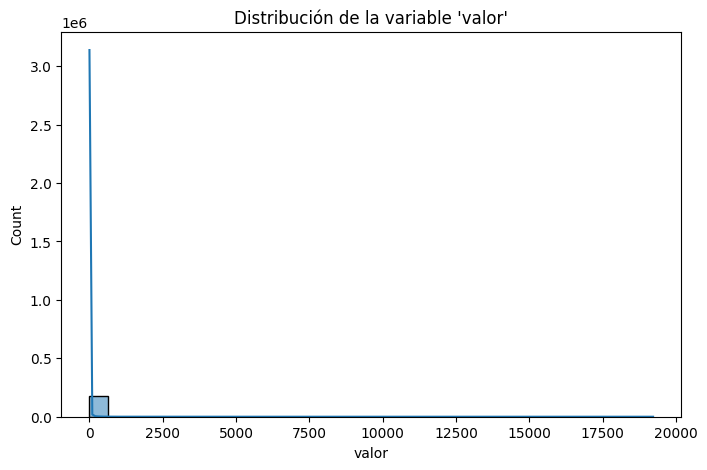

In [23]:
# 3. Distribución de la variable 'valor'
plt.figure(figsize=(8,5))
sns.histplot(df_long["valor"], bins=30, kde=True)
plt.title("Distribución de la variable 'valor'")
plt.show()

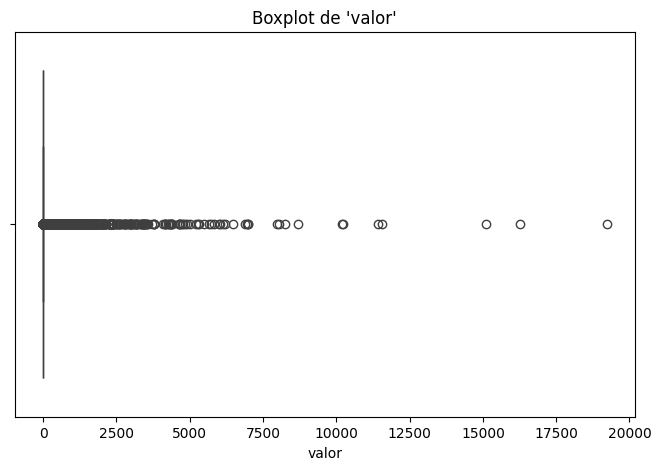

In [24]:
# 4. Boxplot de 'valor' para detectar outliers
plt.figure(figsize=(8,5))
sns.boxplot(x=df_long["valor"])
plt.title("Boxplot de 'valor'")
plt.show()

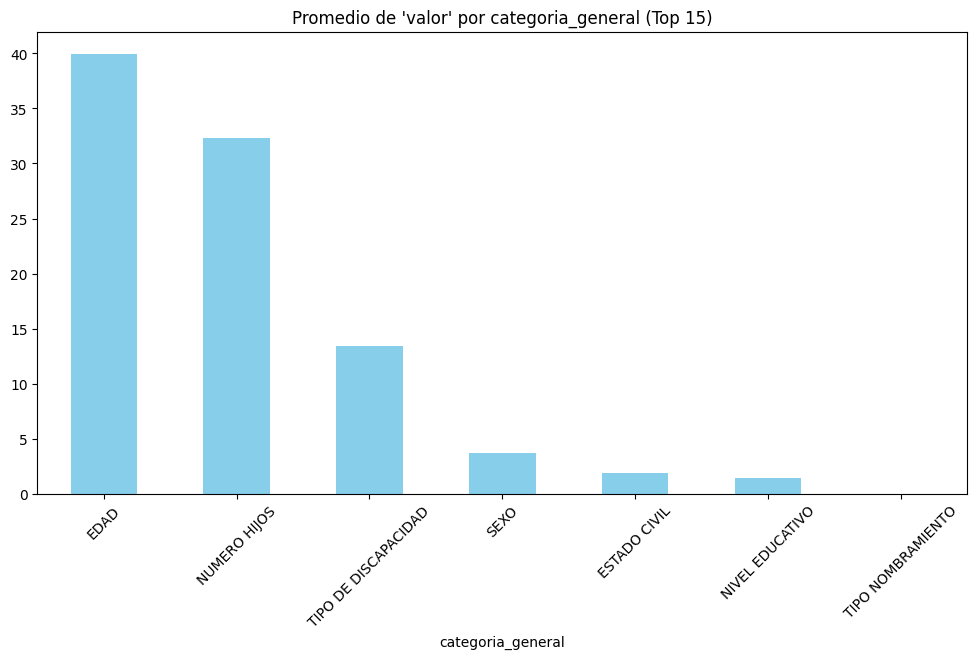

In [25]:
# 5. Promedio de valor por categoria_general
plt.figure(figsize=(12,6))
df_long.groupby("categoria_general")["valor"].mean().sort_values(ascending=False).head(15).plot(kind="bar", color="skyblue")
plt.title("Promedio de 'valor' por categoria_general (Top 15)")
plt.xticks(rotation=45)
plt.show()

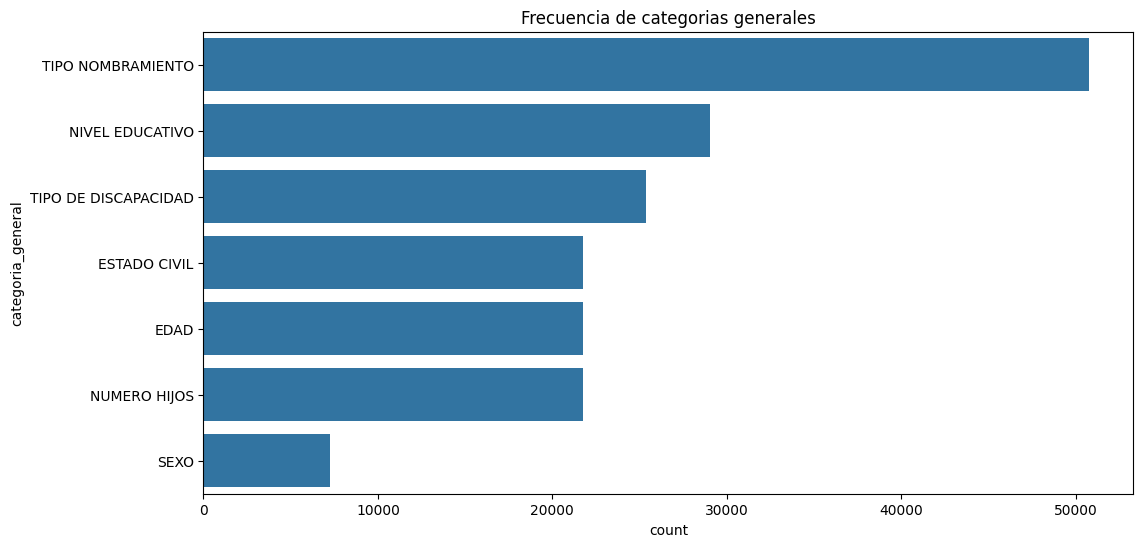

In [26]:
# 6. Conteo de registros por categoria_general
plt.figure(figsize=(12,6))
sns.countplot(data=df_long, y="categoria_general", order=df_long["categoria_general"].value_counts().index)
plt.title("Frecuencia de categorias generales")
plt.show()

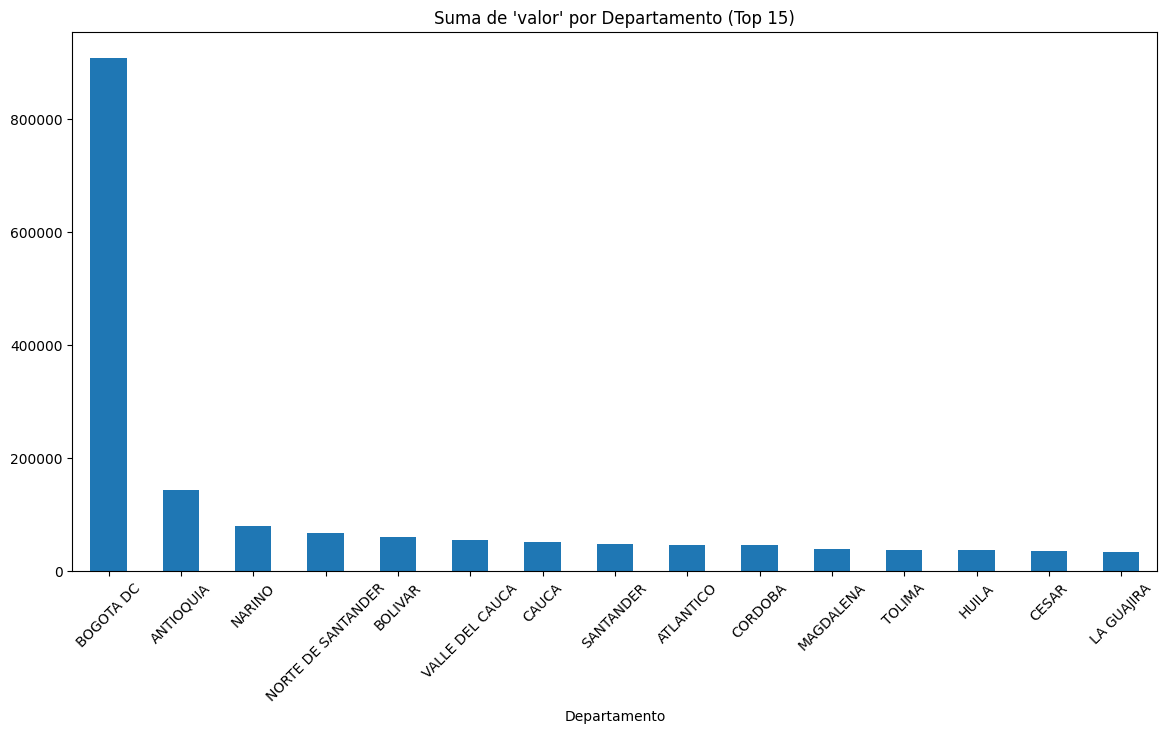

In [27]:
# 7. Distribución de valores por Departamento
plt.figure(figsize=(14,7))
df_long.groupby("Departamento")["valor"].sum().sort_values(ascending=False).head(15).plot(kind="bar")
plt.title("Suma de 'valor' por Departamento (Top 15)")
plt.xticks(rotation=45)
plt.show()

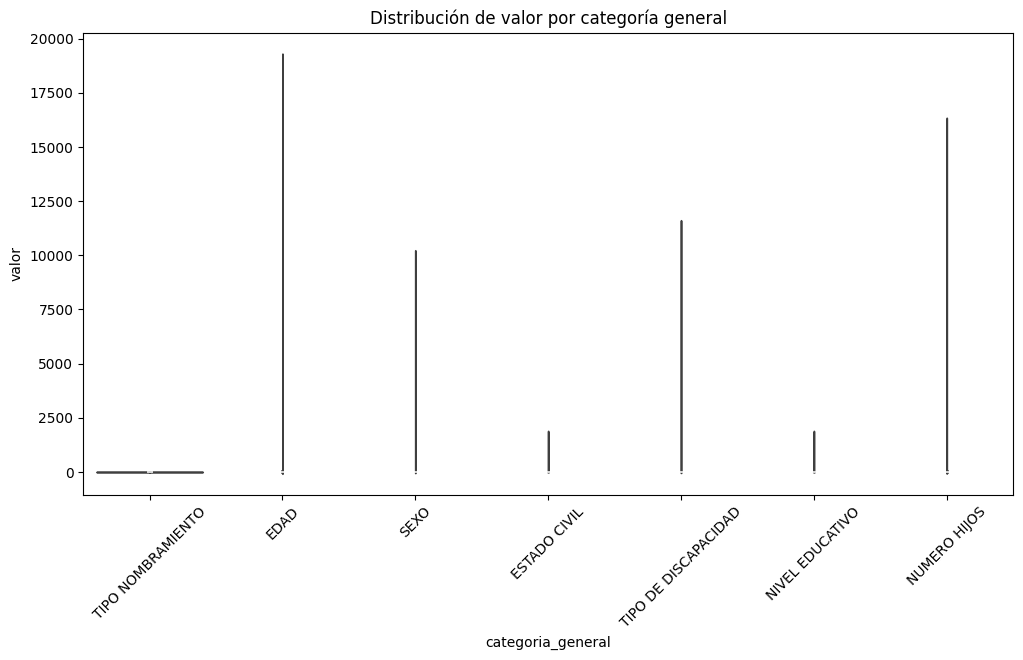

In [28]:
# 8. Distribución de valores por categoría con violinplots

plt.figure(figsize=(12,6))
sns.violinplot(data=df_long, x="categoria_general", y="valor", inner="box")
plt.xticks(rotation=45)
plt.title("Distribución de valor por categoría general")
plt.show()

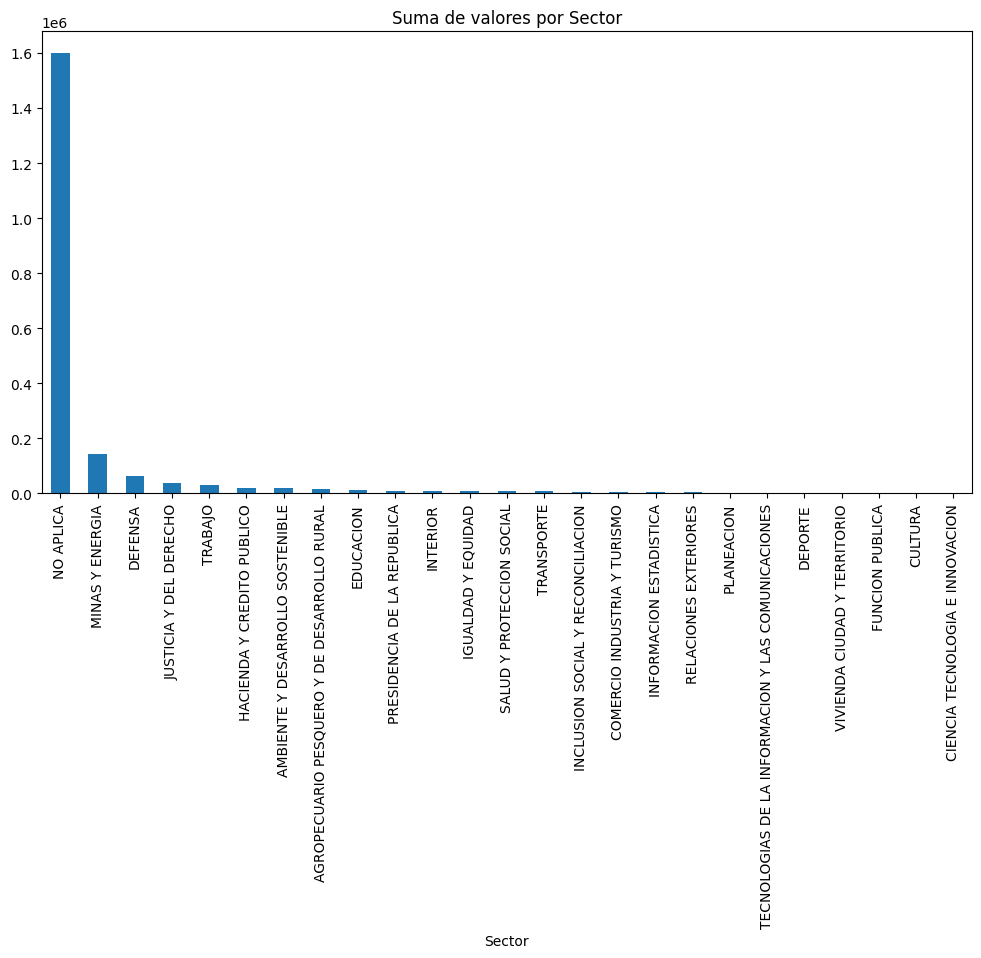

In [29]:
# 9. Relación entre Sector y Valor

df_long.groupby("Sector")["valor"].sum().sort_values(ascending=False).plot(kind="bar", figsize=(12,6))
plt.title("Suma de valores por Sector")
plt.show()

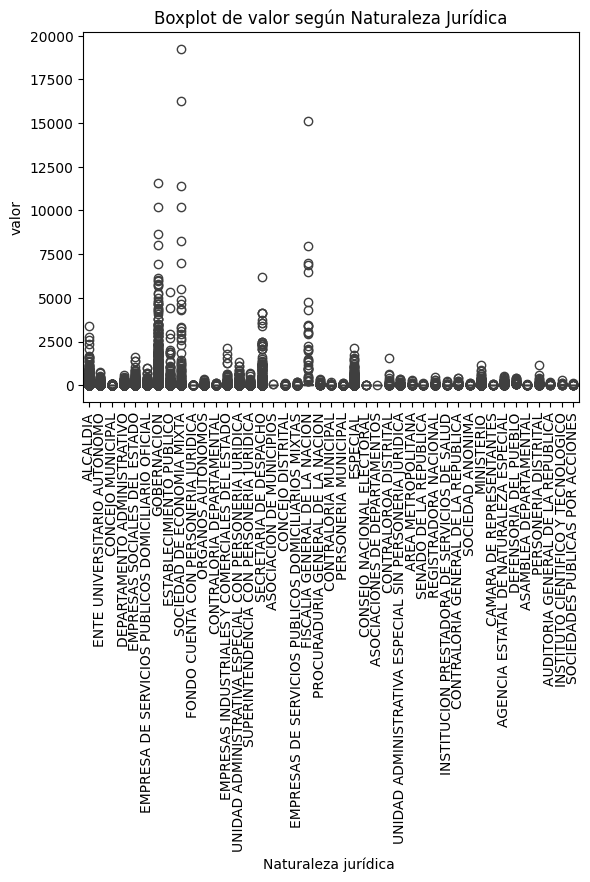

In [30]:
# 10. Naturaleza Jurídica vs Valor

sns.boxplot(data=df_long, x="Naturaleza jurídica ", y="valor")
plt.xticks(rotation=90)
plt.title("Boxplot de valor según Naturaleza Jurídica")
plt.show()

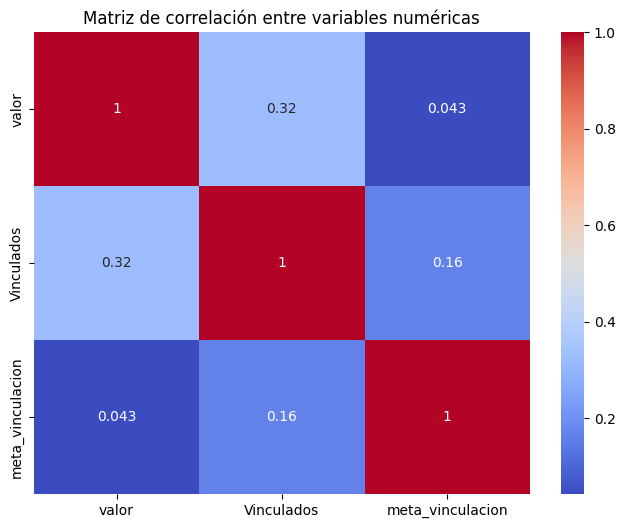

In [31]:
# 11. Correlaciones entre variables numéricas

plt.figure(figsize=(8,6))
sns.heatmap(df_long[["valor","Vinculados","meta_vinculacion"]].corr(), annot=True, cmap="coolwarm")
plt.title("Matriz de correlación entre variables numéricas")
plt.show()

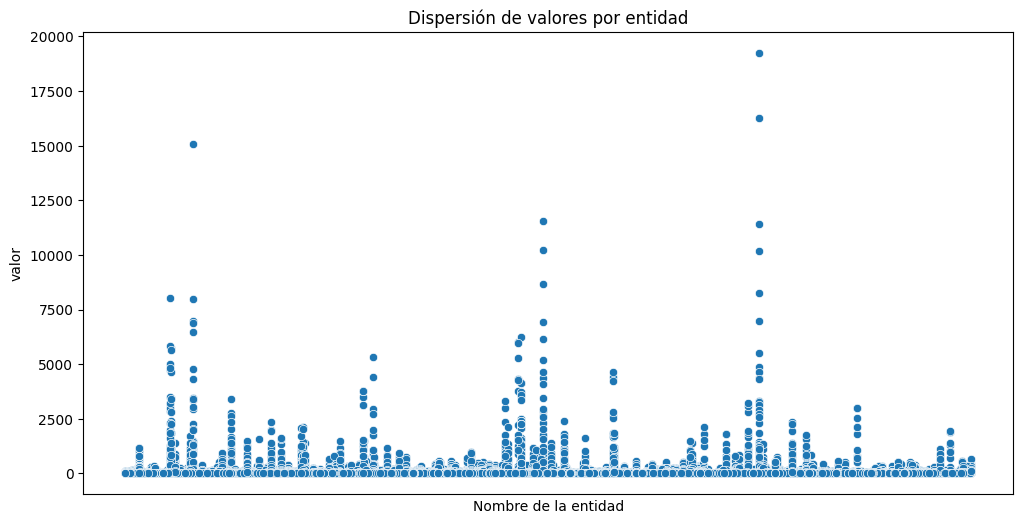

In [32]:
# 12. Detección de outliers por entidad

plt.figure(figsize=(12,6))
sns.scatterplot(data=df_long, x="Nombre de la entidad", y="valor")
plt.xticks([], [])                                         # se ocultan los ticks para que no se vea recargado
plt.title("Dispersión de valores por entidad")
plt.show()

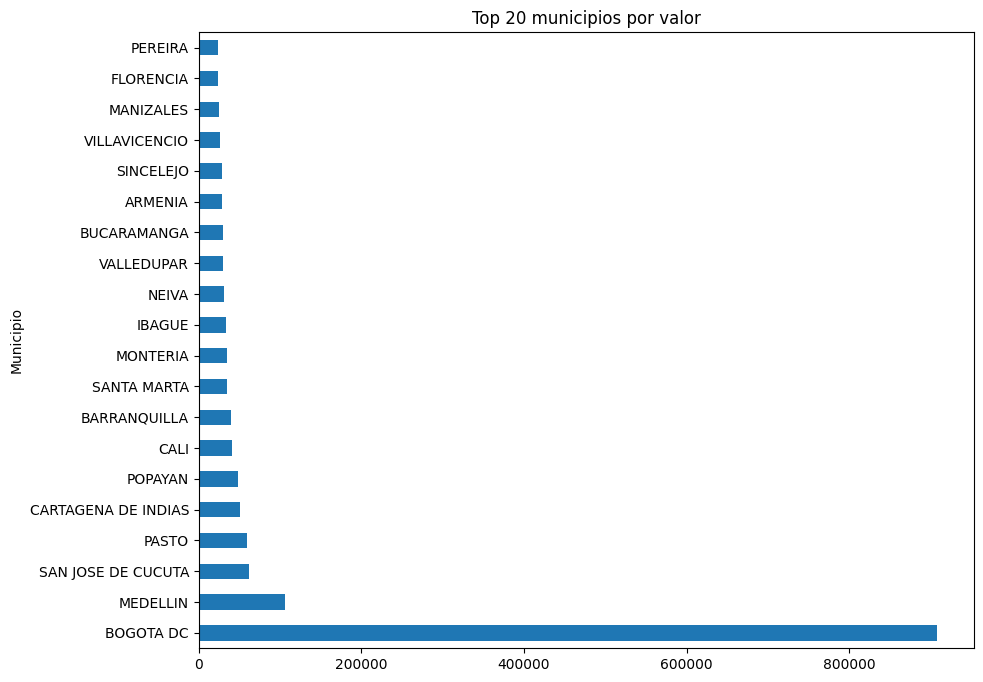

In [33]:
# 13. Ranking de los Top N municipios

df_long.groupby("Municipio")["valor"].sum().nlargest(20).plot(kind="barh", figsize=(10,8))
plt.title("Top 20 municipios por valor")
plt.show()

In [34]:
#output_path = "C:/Users/andpu/OneDrive/Escritorio/ESPECIALIZACION EN ANALITICA DE BIG DATA/SEMESTRE 1/GESTION Y ALMACENAMIENTO DE DATOS/Proyecto Final/Data/vinculacion_largo_limpio.csv"
output_path = "./vinculacion_largo_limpio.csv"
df_long.to_csv(output_path, index=False, encoding="utf-8-sig")
print("CSV generado en:", output_path)

CSV generado en: ./vinculacion_largo_limpio.csv


**BASE DE DATOS**

In [25]:
# Se cargan las variables de entorno para la conexión a la base de datos
load_dotenv(override=True)

True

In [26]:
def get_db_connection():
  '''
  Funcionalidad que permite establecer la conexión a la base de datos PostgreSQL
  Args:
    host (str): Dirección del servidor de la base de datos
    user (str): Nombre de usuario para la conexión
    password (str): Contraseña del usuario
    dbname (str): Nombre de la base de datos a conectar
  Returns:
    conn: Objeto de conexión a la base de datos PostgreSQL
  Raises:
    Exception: Para cualquier otro error inesperado
  '''
  host = os.getenv("DB_HOST", "localhost")
  user = os.getenv("DB_USER", "admin")
  password = os.getenv("DB_PASSWORD", "admin")
  dbname = os.getenv("DB_NAME", "db")

  try:
    conn = psycopg2.connect(
      host = host,
      user = user,
      password = password,
      dbname = dbname
    )
    return conn
  except ConnectionError as ce:
    print(f"Error conectandose a la base de datos: {ce}")
    return None
  except Exception as e:
    print(f"Error inesperado: {e}")
    return None

In [27]:
# Se define un funcion que recibe el dataset e inserta los datos en la tabla
def insert_data_to_db(records_list):
  '''
  Funcionalidad que permite insertar los datos de un DataFrame en una tabla de PostgreSQL
  Args:
    df (pd.DataFrame): DataFrame que contiene los datos a insertar
    table_name (str): Nombre de la tabla en la base de datos donde se insertarán los datos
  Returns:
    None
  Raises:
    Exception: Para cualquier error durante la inserción de datos
  '''
  # Se obtiene la conexión a la base de datos
  conn = get_db_connection()

  # Se obtiene la tabla destino desde las variables de entorno
  table_name = os.getenv("DB_TABLE", "db_discapacidad_laboral")

  if conn is None:
    print("No se pudo establecer la conexión a la base de datos. Abortando inserción.")
    return
  
  table_columns = [
    "nombre_entidad", "orden", "suborden", "departamento", "municipio", "clasificacion_organica", "sector",
    "naturaleza_juridica", "longitud", "latitud", "anio", "salario_mensual_promedio", "vinculados", "meta_vinculacion",
    "cumplimiento", "categoria", "valor", "categoria_general"
  ]

  placeholders = ", ".join(["%s"] * len(table_columns))
  columns_str = ", ".join(table_columns)
  insert_sql = f"INSERT INTO {table_name} ({columns_str}) VALUES ({placeholders})"

  cursor = conn.cursor()

  try:
    execute_batch(cursor, insert_sql, records_list, page_size=500)
    conn.commit()
  except Exception as e:
    conn.rollback()
    print(f"Error al insertar datos: {e}")
  finally:
    cursor.close()
    conn.close()
    print("Conexión a la base de datos cerrada")

In [29]:
# Como llamar la función para insertar los datos
insert_data_to_db(df_long.values.tolist())

Conexión a la base de datos cerrada
